In [4]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import plotnine as pn

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import scale, LabelEncoder

plt.rcParams.update({'font.size': 12})

## Load the data

In [10]:
#load sample information

sample_info = pd.read_excel('./data/samples.xlsx','samples')
sample_info = sample_info[(sample_info['sequencing_type']=='RNAseq') & (sample_info['tissue']!='normal breast')][['sample_ID','brca1']]
sample_info.index = sample_info['sample_ID']
sample_info['brca1'] = sample_info['brca1'].str.replace('flox/flox','Brca1-deleted')
sample_info['brca1'] = sample_info['brca1'].str.replace('WT','Brca1-wildtype')

#exon expression data

exon_counts = pd.read_csv('./data/brca1.exon_counts.rnaseq.csv')
exon_labels = ['exon' + str(i) for i in range(1,24)]
exon_counts.index = exon_labels

# transcriptional data

expr = pd.read_csv('./data/genes-symbols-fpkm.csv',index_col=0)

#get common samples and order samples in same way

s1 = set(sample_info['sample_ID'].tolist())
s2 = set(exon_counts.columns.tolist())
s3 = set(expr.columns.tolist())
common = list(s1.intersection(s2).intersection(s3))

expr = expr[common]
sample_info = sample_info.loc[common,:]
exon_counts = exon_counts[list(common)]


sample_info.head()


,sample_ID,brca1
sample_ID,,
HL164,HL164,Brca1-wildtype
HL33,HL33,Brca1-wildtype
HL112,HL112,Brca1-wildtype
HL168,HL168,Brca1-wildtype
HL127,HL127,Brca1-deleted


The sample_info dataframe contains a bunch of other columns that are not of interest to us.

## Plot per exon counts by brca1 genotype

/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 15 x 5 in image.
  from_inches(height, units), units))
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/exon_counts.png
  warn('Filename: {}'.format(filename))


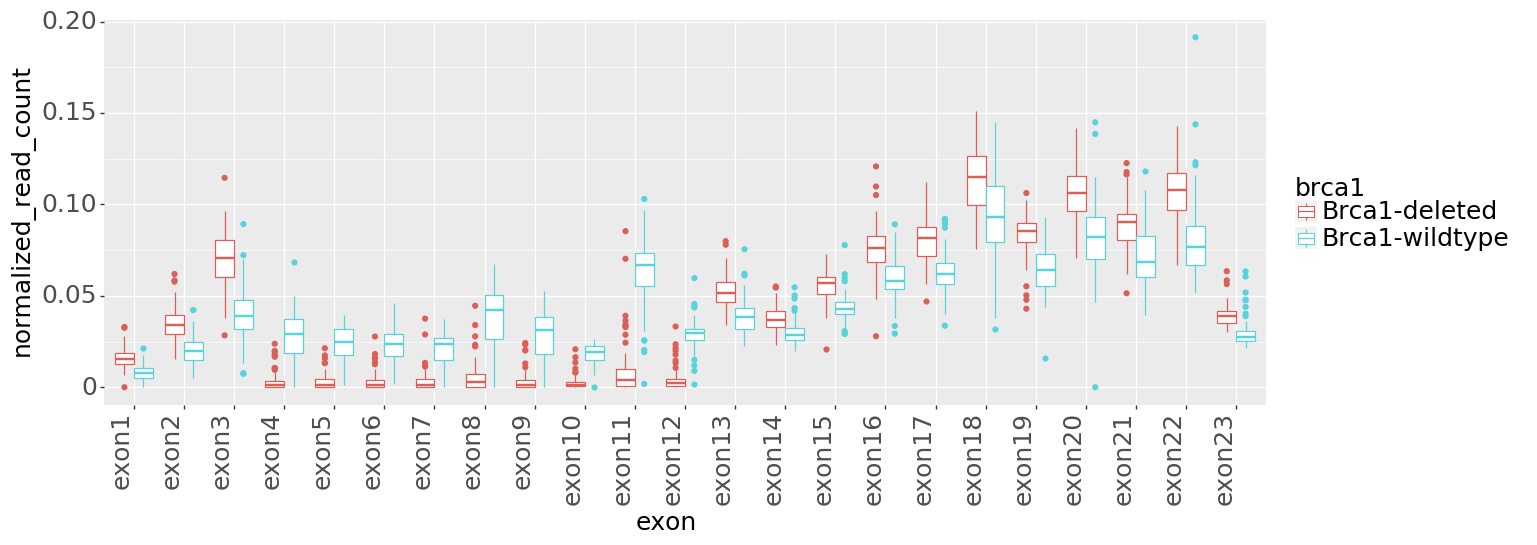

<ggplot: (-9223372029298697121)>

In [620]:
#transform data into something plotnine can use

data = []

for i in exon_counts.index:
    for sample in exon_counts.columns:
        data.append([
            sample,
            sample_info.at[sample,'brca1'],
            i,
            exon_counts.at[i,sample]
        ])
data = pd.DataFrame(data,columns=['sample','brca1','exon','normalized_read_count'])
data['exon'] = pd.Categorical(data['exon'], categories=exon_labels, ordered=True)

# plot the data

p = pn.ggplot(data,pn.aes('exon','normalized_read_count',color='brca1')) + \
    pn.geom_boxplot() + \
    pn.theme(
        text=pn.element_text(size = 18),
        axis_text_x=pn.element_text(rotation=90, hjust=1))
p.save('./plots/exon_counts.png',width=15,height=5)
p


## PCA Analysis

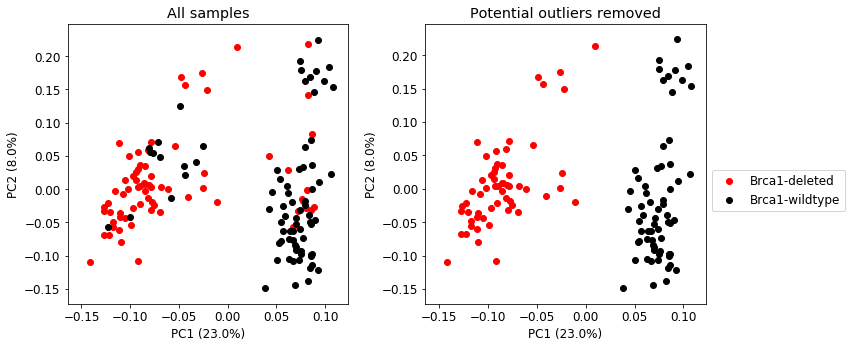

In [11]:
from sklearn.decomposition import PCA

# do the PCA

expr = expr[(expr.T != 0).any()]
expr = expr[expr.std(axis=1)>1]
expr = np.log(expr + 0.1) # log transorm is necessary to avoid heteroskedasticity
expr = scale(expr,axis=1)


pca_sample = PCA(n_components=2)
pca_sample.fit(expr)

genotype = sample_info['brca1'].values

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.scatter(
    pca_sample.components_[0,genotype=='Brca1-deleted'],
    pca_sample.components_[1,genotype=='Brca1-deleted'],
    color='red',label="Brca1-deleted")
ax1.scatter(
    pca_sample.components_[0,genotype=="Brca1-wildtype"],
    pca_sample.components_[1,genotype=="Brca1-wildtype"],
    color='black',label="Brca1-wildtype")
#ax1.legend(bbox_to_anchor=(1, 0.5))
ax1.set_xlabel('PC1 ({0}%)'.format(round(pca_sample.explained_variance_ratio_[0]*100)))
ax1.set_ylabel('PC2 ({0}%)'.format(round(pca_sample.explained_variance_ratio_[1]*100)))
ax1.set_title('All samples')

# remove potentially mislabeled samples and format the data

tmp = pd.DataFrame([
    list(common),
    list(genotype),
    list(pca_sample.components_[0]),
    list(pca_sample.components_[1])
]).T


tmp_nooutliers = tmp[((tmp[1]=='Brca1-deleted') & (tmp[2]<=0.025)) | ((tmp[1]=="Brca1-wildtype") & (tmp[2]>=0.025))]
outliers = set(sample_info.index).difference(tmp_nooutliers[0])

ax2.scatter(
    tmp_nooutliers.loc[tmp_nooutliers[1]=='Brca1-deleted',2],
    tmp_nooutliers.loc[tmp_nooutliers[1]=='Brca1-deleted',3],
    color='red',label="Brca1-deleted")
ax2.scatter(
    tmp_nooutliers.loc[tmp_nooutliers[1]=="Brca1-wildtype",2],
    tmp_nooutliers.loc[tmp_nooutliers[1]=="Brca1-wildtype",3],
    color='black',label="Brca1-wildtype")
ax2.legend(bbox_to_anchor=(1, 0.5))
ax2.set_xlabel("PC1 ({0}%)".format(round(pca_sample.explained_variance_ratio_[0]*100)))
ax2.set_ylabel("PC2 ({0}%)".format(round(pca_sample.explained_variance_ratio_[1]*100)))
ax2.set_title('Potential outliers removed')
plt.tight_layout()
plt.savefig('./plots/pca.png')

## Filter the data base on PCA from expression data

In [12]:
X = exon_counts.T
X_filtered = X.loc[X.index.isin(tmp_nooutliers[0].tolist()),:]
X_filtered = X_filtered.values


y = sample_info["brca1"]
nonoutlier_index = ~sample_info['sample_ID'].isin(outliers)
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
y_filtered = y[nonoutlier_index]

## PCA on the exon expression data

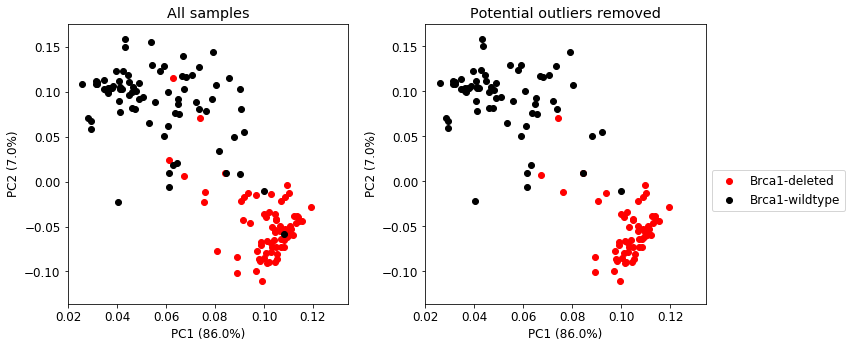

In [623]:


pca = PCA(n_components=2)
pca.fit(X.T)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.scatter(
    pca.components_[0,genotype=='Brca1-deleted'],
    pca.components_[1,genotype=='Brca1-deleted'],
    color='red',label="Brca1-deleted")
ax1.scatter(
    pca.components_[0,genotype=="Brca1-wildtype"],
    pca.components_[1,genotype=="Brca1-wildtype"],
    color='black',label="Brca1-wildtype")
#ax1.legend(bbox_to_anchor=(1, 0.5))
ax1.set_xlabel('PC1 ({0}%)'.format(round(pca.explained_variance_ratio_[0]*100)))
ax1.set_ylabel('PC2 ({0}%)'.format(round(pca.explained_variance_ratio_[1]*100)))
ax1.set_title('All samples')

# remove potentially mislabeled samples and format the data
component_no_outlier = pca.components_[:,nonoutlier_index]


ax2.scatter(
    component_no_outlier[0,y_filtered==0],
    component_no_outlier[1,y_filtered==0],
    color='red',label="Brca1-deleted")
ax2.scatter(
    component_no_outlier[0,y_filtered==1],
    component_no_outlier[1,y_filtered==1],
    color='black',label="Brca1-wildtype")
ax2.legend(bbox_to_anchor=(1, 0.5))
ax2.set_xlabel("PC1 ({0}%)".format(round(pca.explained_variance_ratio_[0]*100)))
ax2.set_ylabel("PC2 ({0}%)".format(round(pca.explained_variance_ratio_[1]*100)))
ax2.set_title('Potential outliers removed')
plt.tight_layout()
plt.savefig('./plots/pca-exon.png')


## Scatter plots
Shows the collinearity among the variables

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


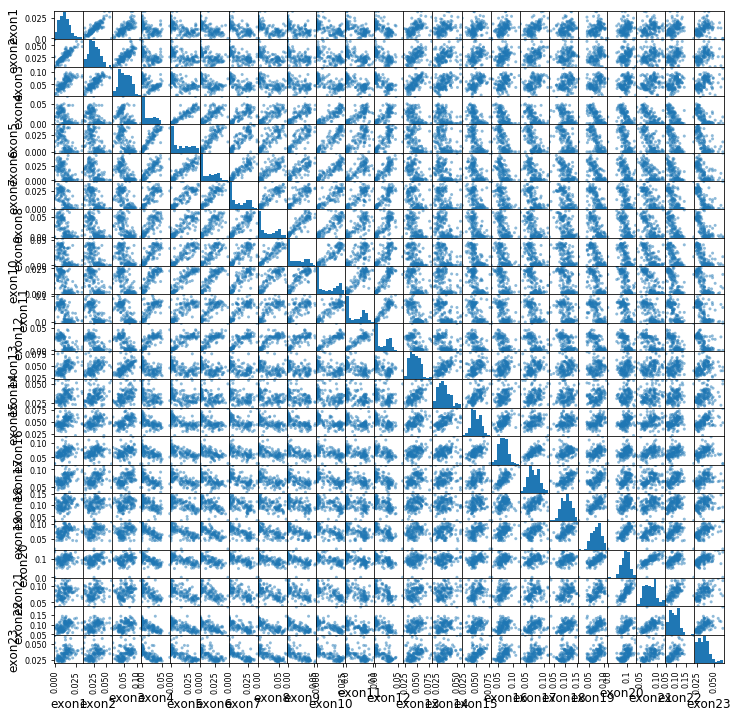

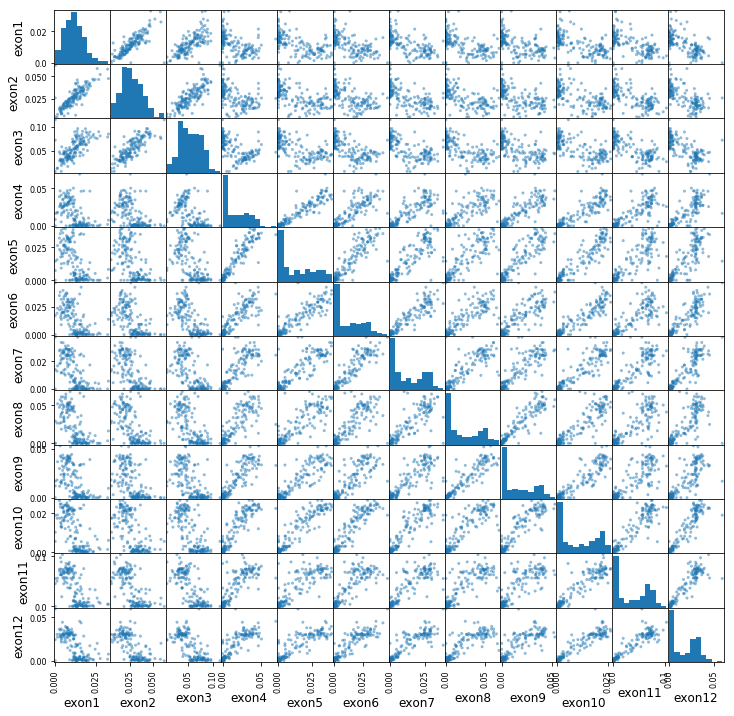

In [624]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(exon_counts.T,figsize=(12,12))
plt.savefig('./plots/scatter-plots.png')

scatter_matrix(exon_counts.T[exon_labels[0:12]],figsize=(12,12))
plt.savefig('./plots/scatter-plots-sub.png')

## PCA on exon expression data

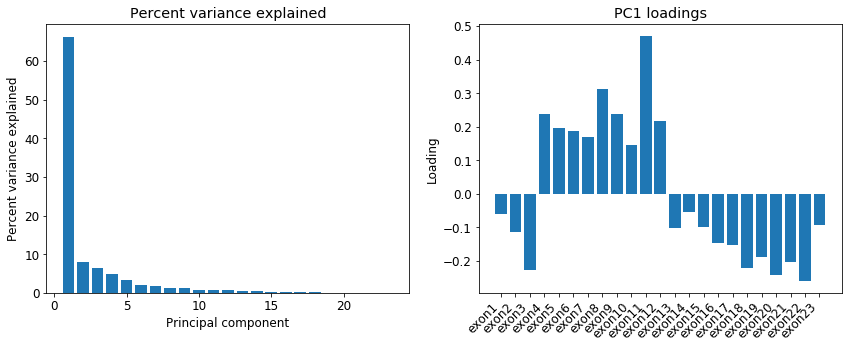

In [625]:
pca = PCA(n_components=23)
pca.fit(X_filtered)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.bar(range(1,24),pca.explained_variance_ratio_*100)
ax1.set_ylabel("Percent variance explained")
ax1.set_xlabel("Principal component")
ax1.set_title('Percent variance explained')

ax2.bar(exon_labels,pca.components_[0,:])
ax2.set_xticklabels(exon_labels,rotation=45,ha='right')
ax2.set_ylabel('Loading')
ax2.set_xlabel('')
ax2.set_title('PC1 loadings')

plt.tight_layout()
plt.savefig('./plots/pca-exons.png')

# Try some models

In [49]:
scores = {}

### Logistic regression

In [58]:
# logistic regression

model = LogisticRegression(solver='liblinear', )
param_grid = {
    'C':[0.1,0.5,1,5,10,100],
    'penalty': ['l2', 'l1']
}

grid_search_lr = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search_lr.fit(X_filtered, y_filtered)

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 0.5, 1, 5, 10, 100], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [ ]:
grid_search_lr.best_estimator_
#grid_search_lr.cv_results_

In [59]:
idx = grid_search_lr.cv_results_['params'].index({'C':5,'penalty':'l2'})
scores['logistic'] = [grid_search_lr.cv_results_['split' + str(i) + '_test_score'][idx] for i in range(10)]

### Linear SVC

In [69]:
# SVC

model = LinearSVC(dual=False, max_iter=20000)
param_grid = {
    'C': [0.1,0.5,1,5,10,100],
    'penalty': ['l1','l2']}
grid_search_lsvc = GridSearchCV(model, param_grid,scoring='accuracy', cv=10)
grid_search_lsvc.fit(X_filtered,y_filtered)

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=20000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 0.5, 1, 5, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [70]:
grid_search_lsvc.best_estimator_
#grid_search_svc.cv_results_

LinearSVC(C=10, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=20000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [71]:
idx = grid_search_lsvc.cv_results_['params'].index({'C': 10, 'penalty': 'l2'},)
scores['linear_svc'] = [grid_search_lsvc.cv_results_['split' + str(i) + '_test_score'][idx] for i in range(10)]

### DecisionTreeClassifier

In [73]:
model = DecisionTreeClassifier()
param_grid = {
    'max_depth': range(3,30,2),
    'max_leaf_nodes': range(2,10),
    'min_samples_leaf':range(1,10),
    'min_samples_split':[2,4,6,8]}
grid_search_dt = RandomizedSearchCV(model,param_grid,cv=10,scoring='accuracy')
grid_search_dt.fit(X_filtered, y_filtered)

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': range(3, 30, 2), 'max_leaf_nodes': range(2, 10), 'min_samples_leaf': range(1, 10), 'min_samples_split': [2, 4, 6, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [ ]:
#scores['DecisionTreeClassifier'] = cross_val_score(grid_search_dt.best_estimator_,X_filtered,y_filtered,cv=10)

In [77]:
grid_search_dt.best_estimator_
#grid_search_dt.cv_results_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=None, max_leaf_nodes=6, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [79]:
idx = grid_search_dt.cv_results_['params'].index({
    'min_samples_split': 2,
    'min_samples_leaf': 3,
    'max_leaf_nodes': 6,
    'max_depth': 25})
scores['decision_tree'] = [grid_search_dt.cv_results_['split' + str(i) + '_test_score'][idx] for i in range(10)]

### LDA

In [81]:
model = LinearDiscriminantAnalysis()
scores['LDA'] = cross_val_score(model,X_filtered,y_filtered,cv=10)

model = LinearDiscriminantAnalysis(shrinkage='auto',solver='lsqr')
scores['LDA_shrink'] = cross_val_score(model,X_filtered,y_filtered,cv=10)

/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/miniconda3/lib/python3.7/site-packages/

/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 10 x 5 in image.
  from_inches(height, units), units))
/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/model-accuracy.png
  warn('Filename: {}'.format(filename))


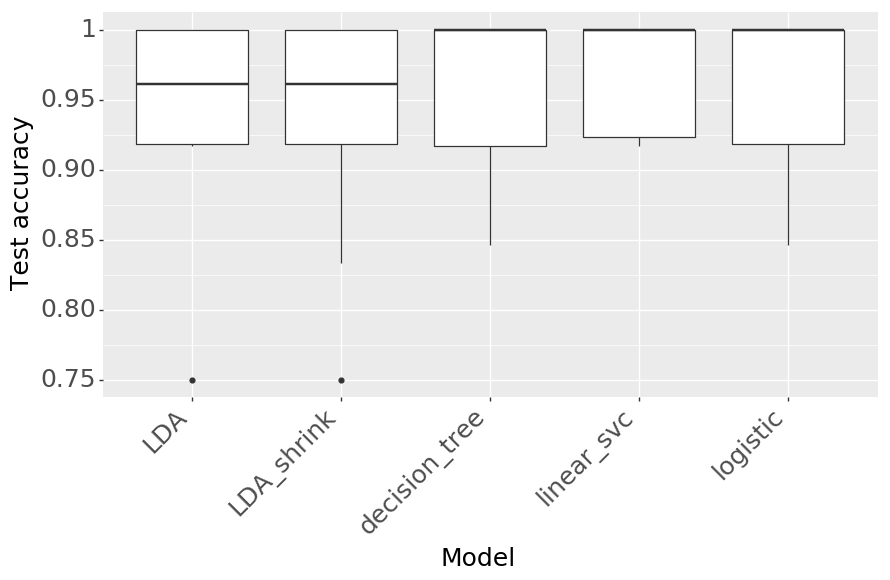

<ggplot: (-9223372029311419013)>

In [82]:
scores = pd.DataFrame(scores)
scores = scores.melt(var_name='Model',value_name='Test accuracy')

pn.options.figure_size = (10,5)
p = pn.ggplot(scores,pn.aes(y='Test accuracy',x='Model')) + \
    pn.geom_boxplot() + \
    pn.theme(axis_text_x = pn.element_text(angle = 45, hjust = 1),text=pn.element_text(size = 18))
p.save('./plots/model-accuracy.png')
p

In [83]:
scores.groupby('Model').agg(['mean','median','std'])

Test accuracy                    
                       mean    median       std
Model                                          
LDA                0.942949  0.961538  0.078652
LDA_shrink         0.934615  0.961538  0.085833
decision_tree      0.958858  1.000000  0.056662
linear_svc         0.967949  1.000000  0.041433
logistic           0.960256  1.000000  0.055457

In [629]:

scores = {}

for i in range(1,15):
    pca = PCA(n_components=i)
    pca.fit(X_filtered)
    X_pca = pca.transform(X_filtered)
    #model = LinearDiscriminantAnalysis()
    
#     model = DecisionTreeClassifier()
#     param_grid = {
#         'max_depth': range(3,30,2),
#         'max_leaf_nodes': range(2,10),
#         'min_samples_leaf':range(1,10),
#         'min_samples_split':[2,4,6,8,10,12]}
#     grid_search_dt = RandomizedSearchCV(model,param_grid,cv=10,scoring='accuracy')
#     grid_search_dt.fit(X_pca, y_filtered)
#     scores[i] = cross_val_score(grid_search_dt.best_estimator_,X_filtered,y_filtered,cv=10)
    
    model = LogisticRegression(C=10000,penalty='l1')
    scores[i] = cross_val_score(model,X_pca,y_filtered,cv=10)

scores = pd.DataFrame(scores)
scores = scores.melt(var_name='Num_PCs',value_name='Test accuracy')
scores = scores.groupby('Num_PCs').agg(['mean'])
scores.columns = scores.columns.levels[0]
#plt.bar(range(1,15),scores['Test accuracy'])
scores

,Test accuracy
Num_PCs,
1,0.951282
2,0.942949
3,0.958974
4,0.942949
5,0.959615
6,0.927564
7,0.935256
8,0.927564
9,0.912179


In [630]:
# here I try to build a model on eigenvector values from
# PCA results where I used the samples as variables.

scores = {}

for i in range(1,15):
    pca = PCA(n_components=i)
    pca.fit(X_filtered.T)
    model = LinearDiscriminantAnalysis()
    
#     model = DecisionTreeClassifier()
#     param_grid = {
#         'max_depth': range(3,30,2),
#         'max_leaf_nodes': range(2,10),
#         'min_samples_leaf':range(1,10),
#         'min_samples_split':[2,4,6,8,10,12]}
#     grid_search_dt = RandomizedSearchCV(model,param_grid,cv=10,scoring='accuracy')
#     grid_search_dt.fit(pca.components_.T, y_filtered)
#     scores[i] = cross_val_score(grid_search_dt.best_estimator_,pca.components_.T,y_filtered,cv=10)
    
    scores[i] = cross_val_score(model,pca.components_.T,y_filtered,cv=10)

scores = pd.DataFrame(scores)
scores = scores.melt(var_name='Num_PCs',value_name='Test accuracy')
scores = scores.groupby('Num_PCs').agg(['mean'])
scores.columns = scores.columns.levels[0]
#plt.bar(range(1,15),scores['Test accuracy'])
scores

,Test accuracy
Num_PCs,
1,0.926807
2,0.967308
3,0.950641
4,0.942949
5,0.942949
6,0.942949
7,0.942949
8,0.942949
9,0.943590


## Predict Brca1 genotype on all samples using logistic regression model

In [91]:
model = LogisticRegression(solver='liblinear', C=5, penalty='l2')
model.fit(X_filtered, y_filtered)

genotype_known = y
X = exon_counts.T.values
y_pred = model.predict(X)


## Show predictions on PCA plot on transcriptional data

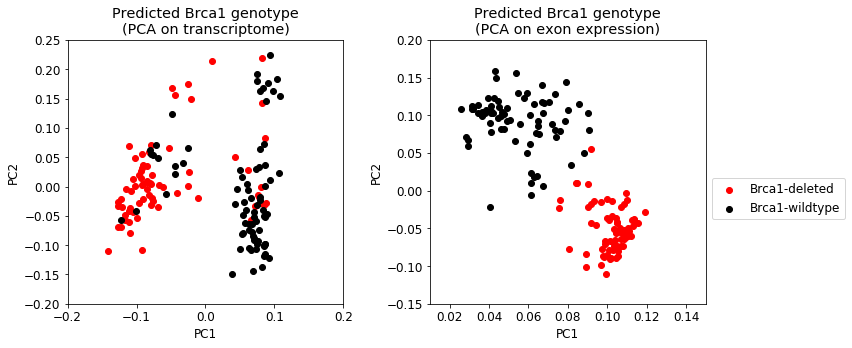

In [92]:
pca_expr = PCA(n_components=2)
pca_expr.fit(expr)

pca_exon = PCA(n_components=2)
pca_exon.fit(X.T)


fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.scatter(
    pca_expr.components_[0,y==0],
    pca_expr.components_[1,y==0],
    color='red',label="Brca1-deleted")
ax1.scatter(
    pca_expr.components_[0,y==1],
    pca_expr.components_[1,y==1],
    color='black',label="Brca1-wildtype")
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Predicted Brca1 genotype\n(PCA on transcriptome)')
ax1.set_ylim(-0.2,0.25)
ax1.set_xlim(-0.2,0.2)

# predictions

ax2.scatter(
    pca_exon.components_[0,y_pred==0],
    pca_exon.components_[1,y_pred==0],
    color='red',label="Brca1-deleted")
ax2.scatter(
    pca_exon.components_[0,y_pred==1],
    pca_exon.components_[1,y_pred==1],
    color='black',label="Brca1-wildtype")
ax2.legend(bbox_to_anchor=(1, 0.5))
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Predicted Brca1 genotype\n(PCA on exon expression)')
ax2.set_ylim(-0.15,0.2)
ax2.set_xlim(0.01,0.15)


plt.tight_layout()
plt.savefig('./plots/pca-prediction.png')

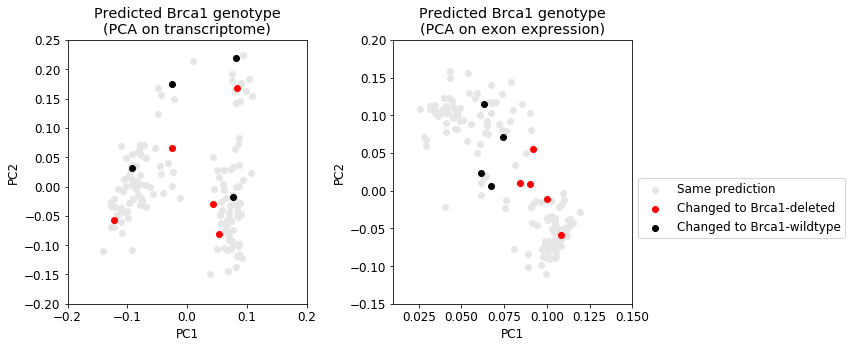

In [93]:
outlier_index = sample_info['sample_ID'].isin(outliers)

pca_expr = PCA(n_components=2)
pca_expr.fit(expr)

pca_exon = PCA(n_components=2)
pca_exon.fit(X.T)


fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(12,5)

#show those that changed genotyp2

ax1.scatter(
    pca_expr.components_[0,y_pred==genotype_known],
    pca_expr.components_[1,y_pred==genotype_known],
    color=(0.9,0.9,0.9),label="Same prediction")
ax1.scatter(
    pca_expr.components_[0,(y_pred!=genotype_known) & (y_pred==0)],
    pca_expr.components_[1,(y_pred!=genotype_known) & (y_pred==0)],
    color='red',label="Changed to Brca1-deleted")
ax1.scatter(
    pca_expr.components_[0,(y_pred!=genotype_known) & (y_pred==1)],
    pca_expr.components_[1,(y_pred!=genotype_known) & (y_pred==1)],
    color='black',label="Changed to Brca1-wildtype")
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Predicted Brca1 genotype\n(PCA on transcriptome)')
ax1.set_ylim(-0.2,0.25)
ax1.set_xlim(-0.2,0.2)


ax2.scatter(
    pca_exon.components_[0,y_pred==genotype_known],
    pca_exon.components_[1,y_pred==genotype_known],
    color=(0.9,0.9,0.9),label="Same prediction")
ax2.scatter(
    pca_exon.components_[0,(y_pred!=genotype_known) & (y_pred==0)],
    pca_exon.components_[1,(y_pred!=genotype_known) & (y_pred==0)],
    color='red',label="Changed to Brca1-deleted")
ax2.scatter(
    pca_exon.components_[0,(y_pred!=genotype_known) & (y_pred==1)],
    pca_exon.components_[1,(y_pred!=genotype_known) & (y_pred==1)],
    color='black',label="Changed to Brca1-wildtype")
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Predicted Brca1 genotype\n(PCA on exon expression)')
ax2.legend(bbox_to_anchor=(1, 0.5))
ax2.set_ylim(-0.15,0.2)
ax2.set_xlim(0.01,0.15)


plt.tight_layout()
plt.savefig('./plots/pca-prediction-difference.png')

## Plots focusing on outliers that were initially removed

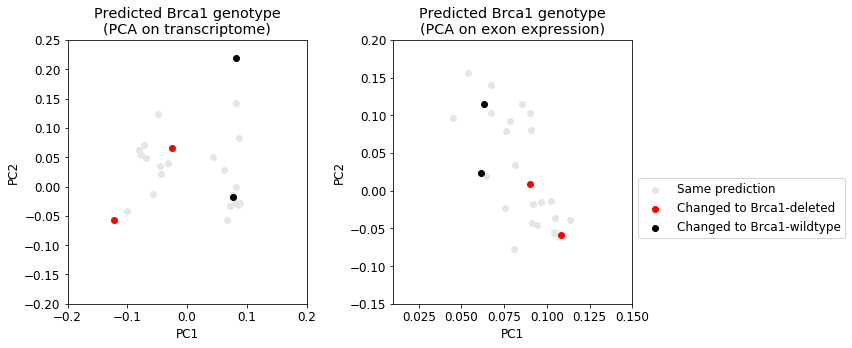

In [94]:

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12,5)

ax1.scatter(
    pca_expr.components_[0,(y_pred==genotype_known) & outlier_index],
    pca_expr.components_[1,(y_pred==genotype_known) & outlier_index],
    color=(0.9,0.9,0.9),label="Same prediction")
ax1.scatter(
    pca_expr.components_[0,(y_pred!=genotype_known) & (y_pred==0) & outlier_index],
    pca_expr.components_[1,(y_pred!=genotype_known) & (y_pred==0) & outlier_index],
    color='red',label="Changed to Brca1-deleted")
ax1.scatter(
    pca_expr.components_[0,(y_pred!=genotype_known) & (y_pred==1) & outlier_index],
    pca_expr.components_[1,(y_pred!=genotype_known) & (y_pred==1) & outlier_index],
    color='black',label="Changed to Brca1-wildtype")
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Predicted Brca1 genotype\n(PCA on transcriptome)')
ax1.set_ylim(-0.2,0.25)
ax1.set_xlim(-0.2,0.2)


ax2.scatter(
    pca_exon.components_[0,(y_pred==genotype_known) & outlier_index],
    pca_exon.components_[1,(y_pred==genotype_known) & outlier_index],
    color=(0.9,0.9,0.9),label="Same prediction")
ax2.scatter(
    pca_exon.components_[0,(y_pred!=genotype_known) & (y_pred==0) & outlier_index],
    pca_exon.components_[1,(y_pred!=genotype_known) & (y_pred==0) & outlier_index],
    color='red',label="Changed to Brca1-deleted")
ax2.scatter(
    pca_exon.components_[0,(y_pred!=genotype_known) & (y_pred==1) & outlier_index],
    pca_exon.components_[1,(y_pred!=genotype_known) & (y_pred==1) & outlier_index],
    color='black',label="Changed to Brca1-wildtype")
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Predicted Brca1 genotype\n(PCA on exon expression)')
ax2.legend(bbox_to_anchor=(1, 0.5))
ax2.set_ylim(-0.15,0.2)
ax2.set_xlim(0.01,0.15)

plt.tight_layout()
plt.savefig('./plots/pca-prediction-difference-outliers.png')

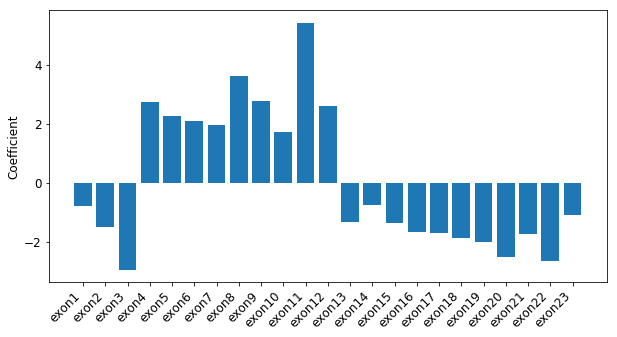

In [96]:
fig = plt.figure(figsize=(10,5))
plt.bar(range(1,24),model.coef_[0,:])
plt.xticks(range(1,24),labels=exon_labels,rotation=45,ha='right')
plt.ylabel('Coefficient')
plt.savefig('./plots/logisticregression-coef.png')